# Comparison of image convolution functions for Gammapy

This notebook is a mini benchmark for image convolution functions, we'd like to use in Gammapy. We will compare:

 * [scipy.ndimage.convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html)
 * [scipy.signal.fftconvolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html#scipy.signal.fftconvolve)
 * [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)
 * [astropy.convolution.convolve](http://docs.astropy.org/en/stable/api/astropy.convolution.convolve.html#astropy.convolution.convolve)
 * [astropy.convolution.convolve_fft](http://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html#astropy.convolution.convolve_fft)
 
On a test image of the size 400 x 400 pixels it turns out that `scipy.signal.fftconvolve` is the fastest of the tested functions, except for very small kernel sizes (< 10 x 10 pixels) where `scipy.ndimage.convolve` is faster. For 
`scipy.signal.fftconvolve` the runtime only weakly depends on the kernel size. Choosing the fft convolution we might
avoid the need for energy dependent kernel sizes.

The benchmark was performed on an Dell Desktop with an i5-3570 CPU @ 3.40GHz × 4 and 8gb of RAM.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import timeit
from scipy.signal import convolve, convolve2d, fftconvolve
from scipy.ndimage import convolve as ndimage_convolve
from scipy.ndimage import gaussian_filter, uniform_filter
from astropy.convolution import convolve as convolve_astropy
from astropy.convolution import convolve_fft as fftconvolve_astropy

In [3]:
np.random.seed(0)

shape = (400, 400)
data = np.random.random(shape)
conv_functions = ['convolve2d', 'fftconvolve', 'ndimage_convolve', 'convolve_astropy', 'fftconvolve_astropy']
kernel_sizes = [5, 11, 21, 41, 81, 161]


In [4]:

results = {}
for conv_function in conv_functions:
    results[conv_function] = []
    
    for kernel_size in kernel_sizes:
        kernel = np.ones((kernel_size, kernel_size))
        timer = timeit.Timer(conv_function + '(data, kernel)', globals=globals())
        value = timer.timeit(2)
        results[conv_function].append(value)

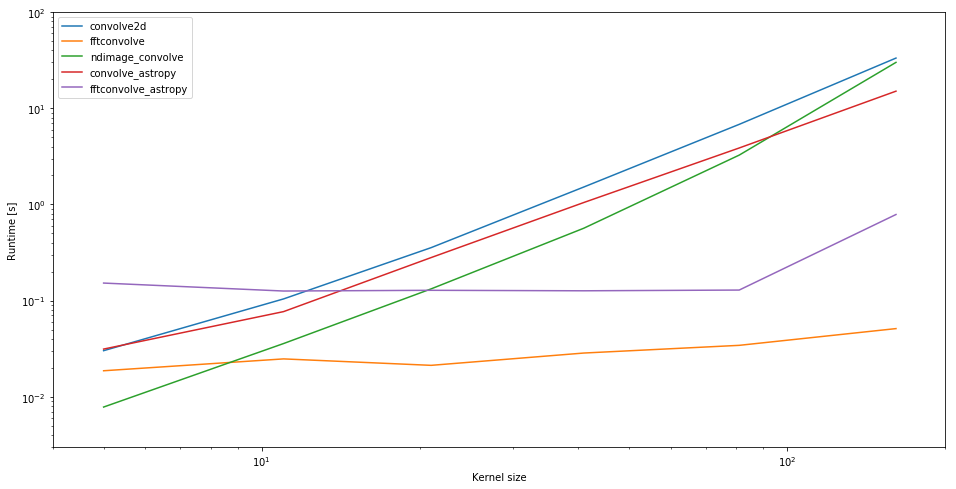

In [5]:
plt.figure(figsize=(16, 8))
for conv_function in conv_functions:
    plt.plot(kernel_sizes, results[conv_function], label=conv_function)
plt.legend(loc='upper left')
plt.loglog()
plt.xlabel('Kernel size')
plt.ylabel('Runtime [s]')
plt.xlim(4, 200)
plt.ylim(0.003, 100)
plt.savefig('convolution_toy_benchmark.png')

To check time for gaussian_filter and uniform_filter as compared to fft_convolve for images

In [6]:
from gammapy.maps import Map, MapAxis, WcsGeom
from astropy.convolution import Tophat2DKernel, Gaussian2DKernel, Box2DKernel
m_gc = Map.create(
    binsz=1.0, width=(10, 5), coordsys="GAL", proj="TAN"
)
m_gc.data = np.random.random(m_gc.data.shape)

In [7]:
kernels = [Gaussian2DKernel, Box2DKernel]

time = {}
name = []
for kernel in kernels:
    time[kernel] = []
    name.append(str(kernel).split(".")[-1])
    for width in kernel_sizes:
        disk = kernel(width)
        ker = disk.array
        timer = timeit.Timer('m_gc.convolve(ker)', globals=globals())
        value = timer.timeit(2)
        time[kernel].append(value)
    

In [8]:
print(time)
print(name)

{<class 'astropy.convolution.kernels.Gaussian2DKernel'>: [0.1474187609856017, 0.003196342004230246, 0.010382145002949983, 0.01930725498823449, 0.08462208401761018, 0.3613254070223775], <class 'astropy.convolution.kernels.Box2DKernel'>: [0.0011870049929711968, 0.0011610800283960998, 0.001226217020303011, 0.0015165530203375965, 0.0019357949786353856, 0.01186385701294057]}
["Gaussian2DKernel'>", "Box2DKernel'>"]


In [9]:

conv_func=['gaussian_filter', 'uniform_filter']
for func in conv_func:
    name.append(func)
    time[func] = []
    for width in kernel_sizes:
        timer = timeit.Timer(func + '(data, width)', globals=globals())
        value = timer.timeit(2)
        time[func].append(value)
    

(0.0008686256487468396, 0.5146142136384171)

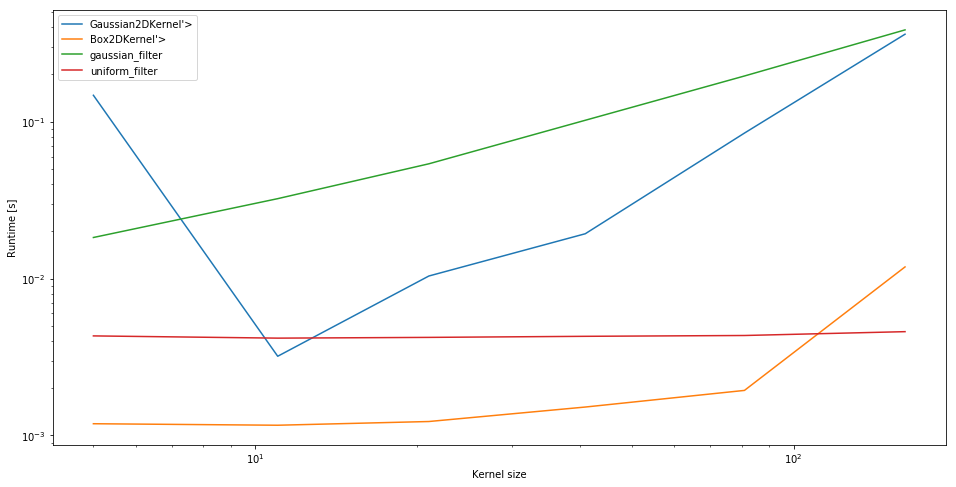

In [10]:
plt.figure(figsize=(16, 8))
names = kernels + conv_func
i = 0
for aname in names:
    plt.plot(kernel_sizes, time[aname], label=name[i])
    i = i + 1
plt.legend(loc='upper left')
plt.loglog()
plt.xlabel('Kernel size')
plt.ylabel('Runtime [s]')
plt.xlim()
plt.ylim()